# DeepAR Experimental Notebook

DeepAR is a machine learning algorithm provided by Amazon Sagemaker for time series. It uses RNN to make point and probabilistic predictions.  
  
This notebook goes through the steps of training a model and using it to make predictions. 

The notebook was intended for use on forecasting hourly patient census data for Medecipher during Colorado School of Mines Field Session

<em>Created by Connor Graflund</em>

In [1]:
# Imports go here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import json
import boto3
import s3fs
import math

from datetime import datetime

# Step 1: Reading data from csv to a Pandas dataframe

After the raw data is read in, convert the date and hour features into a single DateTime feature for DeepAR  
DeepAR takes into account hour and day of week, so they are not needed as features.

In [2]:
# Read the csv file into a pandas dataframe
raw_data = pd.read_csv("LF_data1.csv")

# Make sure data loaded correctly
print(raw_data.head())

       Date  Day of Week  Hour  Count
0  1/1/2018            0     1      0
1  1/1/2018            0     2      0
2  1/1/2018            0     3      0
3  1/1/2018            0     4      0
4  1/1/2018            0     5      0


In [3]:
# Convert Date and Hour feature to datetime64
convert_data = raw_data.copy()
convert_data['Hour'] = pd.to_datetime(convert_data['Hour'], format='%H')
convert_data['Hour'] = pd.Series([val.time() for val in convert_data['Hour']])
convert_data['Date'] = pd.to_datetime(convert_data['Date'])
convert_data['DateTime'] = pd.to_datetime(convert_data['Date'].astype(str) + ' ' + convert_data['Hour'].astype(str))
convert_data = convert_data[['DateTime','Day of Week','Count']]
convert_data.set_index('DateTime')
convert_data.head(5)

,DateTime,Day of Week,Count
0,2018-01-01 01:00:00,0,0
1,2018-01-01 02:00:00,0,0
2,2018-01-01 03:00:00,0,0
3,2018-01-01 04:00:00,0,0
4,2018-01-01 05:00:00,0,0


# Step 2: Train test Split

Ajusting the training size can lead to better results.   
Smaller training sizes can reduce overfitting.

Initial given Times for training and testing:  
2-week training: (3/3/2019 00:00:00 - 12/28/2019 23:00:00) testing: (12/29/2019 00:00:00 - 1/11/2020 23:00:00)  
6-week training: (3/3/2019 00:00:00 - 12/28/2019 23:00:00) testing: (12/29/2019 00:00:00 - 2/8/2020 23:00:00)

In [4]:
# Split the data into training and testing
start_train = pd.Timestamp("8/6/2019 00:00:00")
end_train = pd.Timestamp("12/28/2019 23:00:00")
start_test = pd.Timestamp("12/29/2019 00:00:00")
#end_test = pd.Timestamp("1/11/2020 23:00:00") # 2 week forcast
end_test = pd.Timestamp("2/8/2020 23:00:00") # 6 week forcast

# Training data is from March 3, 2019, 12:00 am - December 28, 2019, 11:00 pm
train_data = convert_data[(convert_data.DateTime >= start_train) & (convert_data.DateTime <= end_train)]

# Testing data is from December 29, 2019, 12:00 am - January 11, 2020, 11:00 pm.
test_data = convert_data[(convert_data.DateTime >= start_test) & (convert_data.DateTime <= end_test)]

In [5]:
# Reset the indexes of both sets to 0
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Step 3: Data Visualization
Some simple matplot lib visualizations to make sure the data is split correctly and to get a good sense of the dataset.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


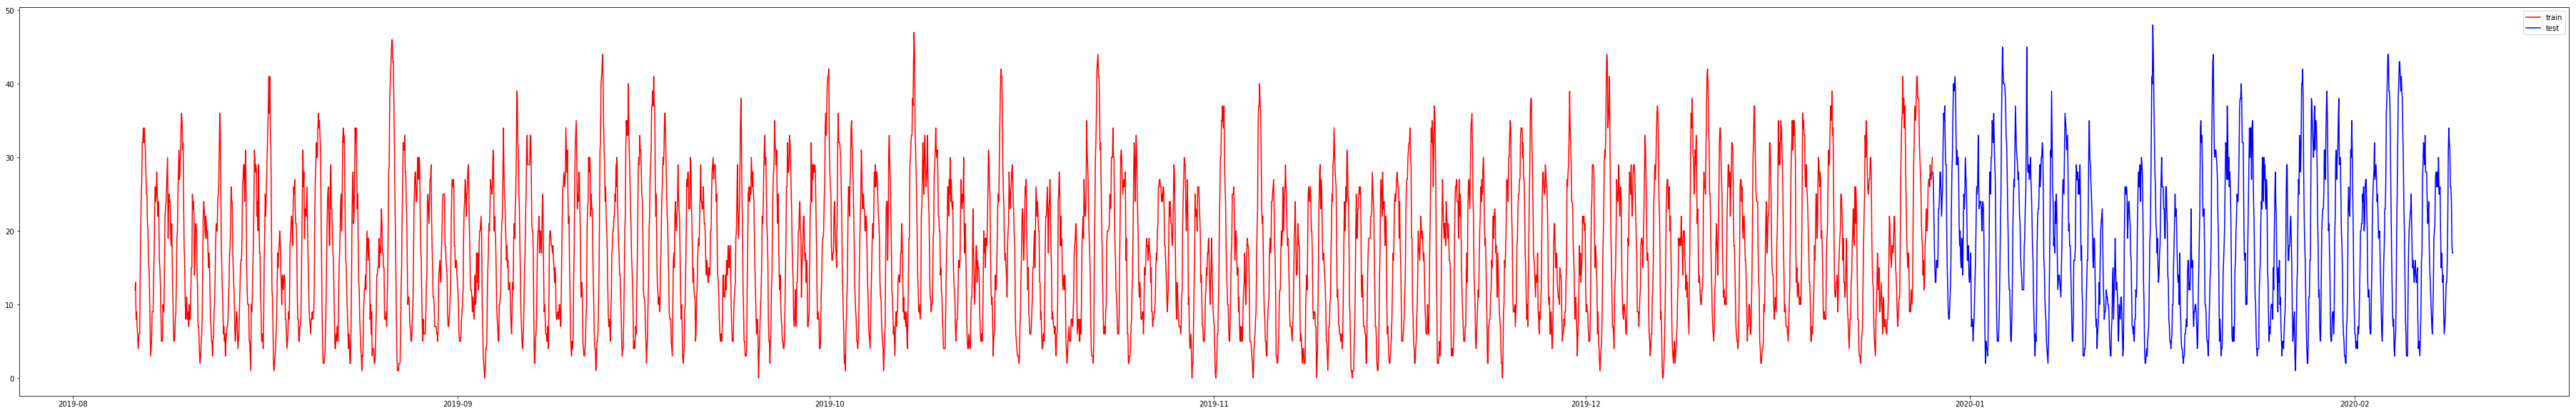

In [6]:
# Time-Series graph of the train and test data
# Training data is shown in blue, testing in orange
fig = plt.figure()
fig.set_size_inches(64,10)
plt.plot(train_data['DateTime'], train_data['Count'], label='train', color='red')
plt.plot(test_data['DateTime'], test_data['Count'], label='test', color='blue')
plt.legend()
plt.show()

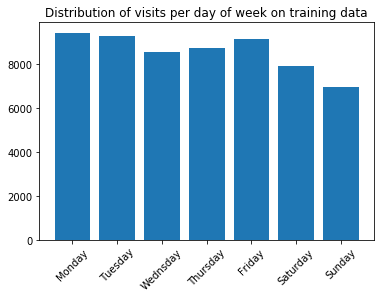

In [7]:
# Show the distribution of visits by day of week
# NOTE: This may be slightly misleading, adds patients multiple times 
plt.hist(train_data['Day of Week'], weights=train_data['Count'], bins=7, align='left', rwidth=.8, range=(0,7))
plt.title("Distribution of visits per day of week on training data")
plt.xticks([0,1,2,3,4,5,6], labels=['Monday', 'Tuesday', 'Wednsday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.show()

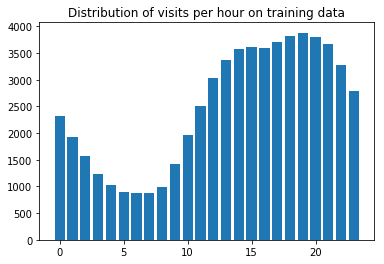

In [8]:
# Show the distribution of visits by hour of day
plt.hist(train_data['DateTime'].dt.hour, weights=train_data['Count'], bins=24, align='left', rwidth=.8, range=(0,24))
plt.title("Distribution of visits per hour on training data")
plt.show()

# Step 4: Create and copy JSON files to an S3 Bucket

Data needs to be converted to a json file for DeepAR. The format is as follows:
{"start:" "date", "target:" [count,...], "dynamic_feat:" [day_of_week,...]}
Create two JSON files: train.json and test.json with the corresponding data  

S3 Bucket is stored on the amazon workspace. DeepAR reads the input data from the bucket.

In [9]:
# Setting up sagemaker
sagemaker_session = sagemaker.Session()
s3_bucket = 'mines-bucket' # Specify the name of the bucket you want to store data in
s3_prefix = 'mines-data-model' 
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

In [10]:
# Specify the directories for the data
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [12]:
# Returns the given dataframe as a JSON lines object formatted for DeepAR
# If dynamic is set to true, use the day of week as a dynamic feature
# It seems like DeepAR already takes into account the day of week when training
def df_to_jsonline(data, dynamic=False):
    if dynamic:
        obj = {"start": str(data.iloc[0].DateTime), "target": data['Count'].tolist(), "dynamic_feat": [train_data['Day of Week'].tolist()]}
    else:
        obj = {"start": str(data.iloc[0].DateTime), "target": data['Count'].tolist()}
    return obj

In [13]:
# Write the dataset as a JSON lines object to a json file
def writeDataset(path, data):
    with open(path, 'wb') as fp:
        line = json.dumps(df_to_jsonline(data))
        fp.write(line.encode('utf-8'))

In [14]:
# Wrtie both the training and testing dataframes to JSON files
writeDataset("train.json", train_data)
writeDataset("test.json", test_data)

In [15]:
# Copy the json files to the S3 Bucket for DeepAR
# Taken from sagemaker example notebook
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=True):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [16]:
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Overwriting existing file
Uploading file to s3://mines-bucket/mines-data-model/data/train/train.json
Overwriting existing file
Uploading file to s3://mines-bucket/mines-data-model/data/test/test.json


# Step 5: Choose hyperparameters and run model

Changing hyperparameters can result in a better model. Model will train on amazon workspace, will take a while to launch ML instances and train depending on data sizes and parameters.

In [17]:
# Time to train the model!
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='DeepAR-Model',
    output_path=s3_output_path
)

In [18]:
# Count is recorded every hour
freq = '1H'

# Predict for length of test set
prediction_length = test_data.shape[0]

# Should be set around the same as prediction length
# Try different ratios to get better results
context_length = int(prediction_length * 2/3)

In [19]:
# Set the hyperparamerters (using defaults for now)
hyperparameters = {
    "time_freq": freq,
    "epochs": "20",
    "mini_batch_size": "256",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [20]:
estimator.set_hyperparameters(**hyperparameters)

In [21]:
data_channels = {
    "train": s3_data_path + "/train/",
    "test": s3_data_path + "/test/"
}

In [22]:
# Fit the model. This cell will take a while to run
estimator.fit(inputs=data_channels, wait=True)

2020-06-10 15:38:35 Starting - Starting the training job...
2020-06-10 15:38:37 Starting - Launching requested ML instances......
2020-06-10 15:40:02 Starting - Preparing the instances for training......
2020-06-10 15:40:45 Downloading - Downloading input data...
2020-06-10 15:41:28 Training - Training image download completed. Training in progress.Arguments: train
[06/10/2020 15:41:30 INFO 140338916456256] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': 

[06/10/2020 15:45:13 INFO 140338916456256] Epoch[2] Batch[5] avg_epoch_loss=3.183353
[06/10/2020 15:45:13 INFO 140338916456256] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=3.18335310618
[06/10/2020 15:45:13 INFO 140338916456256] Epoch[2] Batch [5]#011Speed: 44.86 samples/sec#011loss=3.183353
[06/10/2020 15:45:36 INFO 140338916456256] processed a total of 2545 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 58788.21516036987, "sum": 58788.21516036987, "min": 58788.21516036987}}, "EndTime": 1591803936.151173, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1591803877.362621}

[06/10/2020 15:45:36 INFO 140338916456256] #throughput_metric: host=algo-1, train throughput=43.2909026802 records/second
[06/10/2020 15:45:36 INFO 140338916456256] #progress_metric: host=algo-1, completed 15 % of epochs
[06/10/2020 15:45:36 INFO 140338916456256] #quality_metric: host=algo-1, epoch=2, train loss <loss>=3.148800

[06/10/2020 15:51:37 INFO 140338916456256] Epoch[9] Batch[0] avg_epoch_loss=2.682222
[06/10/2020 15:51:37 INFO 140338916456256] #quality_metric: host=algo-1, epoch=9, batch=0 train loss <loss>=2.68222165108
[06/10/2020 15:52:06 INFO 140338916456256] Epoch[9] Batch[5] avg_epoch_loss=2.662779
[06/10/2020 15:52:06 INFO 140338916456256] #quality_metric: host=algo-1, epoch=9, batch=5 train loss <loss>=2.66277929147
[06/10/2020 15:52:06 INFO 140338916456256] Epoch[9] Batch [5]#011Speed: 45.01 samples/sec#011loss=2.662779
[06/10/2020 15:52:34 INFO 140338916456256] Epoch[9] Batch[10] avg_epoch_loss=2.663871
[06/10/2020 15:52:34 INFO 140338916456256] #quality_metric: host=algo-1, epoch=9, batch=10 train loss <loss>=2.6651804924
[06/10/2020 15:52:34 INFO 140338916456256] Epoch[9] Batch [10]#011Speed: 44.94 samples/sec#011loss=2.665180
[06/10/2020 15:52:34 INFO 140338916456256] processed a total of 2595 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 64425.1708984375, "sum": 644

[06/10/2020 15:57:46 INFO 140338916456256] processed a total of 2475 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 58822.296142578125, "sum": 58822.296142578125, "min": 58822.296142578125}}, "EndTime": 1591804666.096239, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1591804607.27353}

[06/10/2020 15:57:46 INFO 140338916456256] #throughput_metric: host=algo-1, train throughput=42.0757970448 records/second
[06/10/2020 15:57:46 INFO 140338916456256] #progress_metric: host=algo-1, completed 75 % of epochs
[06/10/2020 15:57:46 INFO 140338916456256] #quality_metric: host=algo-1, epoch=14, train loss <loss>=2.49399983883
[06/10/2020 15:57:53 INFO 140338916456256] Epoch[15] Batch[0] avg_epoch_loss=2.485210
[06/10/2020 15:57:53 INFO 140338916456256] #quality_metric: host=algo-1, epoch=15, batch=0 train loss <loss>=2.48521018028
[06/10/2020 15:58:22 INFO 140338916456256] Epoch[15] Batch[5] avg_epoch_loss=2.490386
[06/10/202

#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 98825.40893554688, "sum": 98825.40893554688, "min": 98825.40893554688}}, "EndTime": 1591805071.987008, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1591804973.16065}

[06/10/2020 16:04:35 INFO 140338916456256] Number of GPUs being used: 0
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 101964.45107460022, "sum": 101964.45107460022, "min": 101964.45107460022}}, "EndTime": 1591805075.12601, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1591805071.987182}

[06/10/2020 16:04:35 INFO 140338916456256] Serializing to /opt/ml/model/model_algo-1
[06/10/2020 16:04:35 INFO 140338916456256] Saved checkpoint to "/opt/ml/model/model_algo-1-0000.params"
#metrics {"Metrics": {"model.serialize.time": {"count": 1, "max": 436.3689422607422, "sum": 436.3689422607422, "min": 436.3689422607422}}, "EndTime": 1591805075.562478, "Dimen

# Step 6: Create an endpoint

Endpoint is stored in the amazon workspace. Call the endpoint from the jupyter notebook, returns predictions from given data

In [23]:
# Create endpoint and predictor. This cell will take about 5 minutes to run
job_name = estimator.latest_training_job.name # Choose the latest training job
#job_name = 'data-model-test-2020-05-14-21-53-15-613' # Choose the specified training job

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

---------------!

In [63]:
# Use this cell to use an existing endpoint
endpoint_name = "DeepAR-Model-2020-06-10-15-38-35-301"

In [64]:
# Class borrowed and modified from the sagemaker tutorial
# Creates a DeepARPredictor object. Used to make predictions by encoding requests
# and decoding responsed returned by the endpoint
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=int(prediction_length), quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = 0 #[x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [df_to_jsonline(ts)]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        return pd.DataFrame(data=response_data['predictions'][0]['quantiles'])


# Step 7: Make predictions
Use the predictor to get results from the model. Calculate error metrics using test data.

In [65]:
# Instantiate the predictor object
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
# Set the paramaters to the same used to train the model
predictor.set_prediction_parameters(freq, prediction_length)

In [66]:
# Store the predictions in a pandas dataframe
predict_data = predictor.predict(test_data)

In [67]:
# Set the index for test data to the datetime feature
time_list = pd.date_range(test_data.iloc[0].DateTime, periods=prediction_length, freq=freq)
tl = time_list.to_frame()
tl = tl.reset_index(drop=True)
forecast_data = predict_data.join(tl)
forecast_data = forecast_data.set_index(0, drop=True)


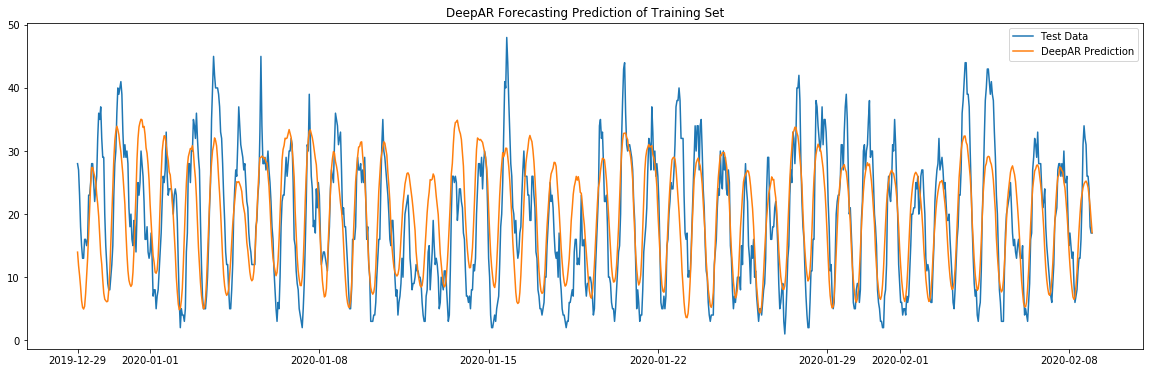

In [68]:
plt.figure(figsize=(20,6))
plt.plot(test_data['DateTime'], test_data['Count'], label='Test Data')
plt.plot(forecast_data['0.5'], label="DeepAR Prediction")
plt.legend()
plt.title("DeepAR Forecasting Prediction of Training Set")

plt.show()

In [69]:
# Calculate Error Metrics
error_sum = 0
error_squared_sum = 0
error_percent_sum = 0
error_one_sided_sum = 0
n_oneside = 0

for i in range(forecast_data.shape[0]):
    error = test_data.at[i, 'Count'] - forecast_data['0.5'][i]
    if (test_data.at[i,'Count'] != 0):
        percent = 100 * error/test_data.at[i,'Count']
    else:
        percent = 0
    error_sum += abs(error)
    error_squared_sum += error**2
    error_percent_sum += abs(percent)
    if(error > 0):
        error_one_sided_sum += error
        n_oneside += 1
  
    

n = forecast_data.shape[0]
RMSE = math.sqrt(error_squared_sum/n)
MAE = error_sum/n
MAPE = error_percent_sum/n
OSE = error_one_sided_sum/n_oneside


print("MAE: ", MAE)
print("RMSE: ", RMSE)
print("MAPE: ", MAPE)
print("OSE: ", OSE)

MAE:  5.512599222951883
RMSE:  6.868693680763073
MAPE:  46.12873213693365
OSE:  5.985799721224764


In [70]:
# Write the error metrics to a CSV file
#open('Error_Metrics_2_week.csv', 'a').write('{},{},{},{},{},{}\n'.format(start_train,end_train,MAE,RMSE,MAPE, OSE))

In [71]:
# Calculate the difference between the test and predicted data, store in error df
forecast_df = forecast_data['0.5'].to_frame()
forecast_df = forecast_df.reset_index(0)
error_df = test_data.join(forecast_df)
error_df['Error'] = error_df['Count'] - error_df['0.5']


Text(0.5, 1.0, 'Error Monitoring Chart for DeepAR')

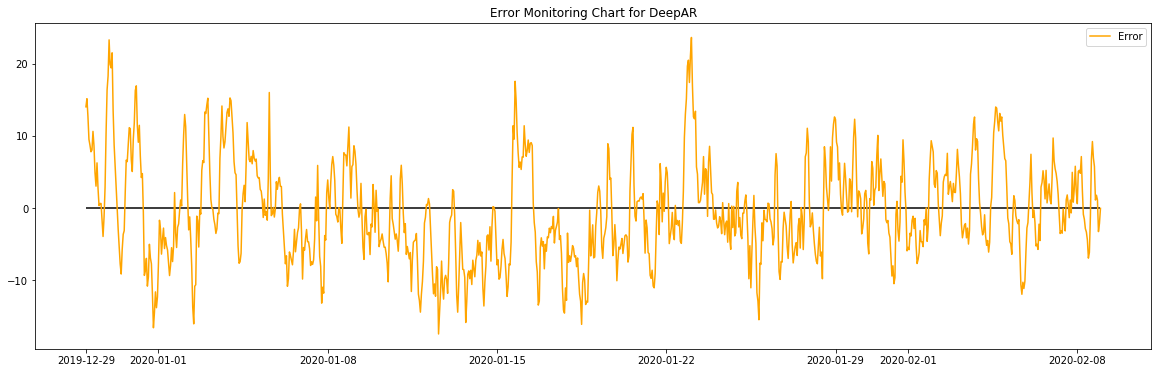

In [72]:
# Error monitoring chart for DeepAR
plt.figure(figsize=(20,6))
plt.plot(error_df['DateTime'], error_df['Error'], label='Error', color='orange')
plt.hlines(0, start_test, end_test)

plt.legend()
plt.title("Error Monitoring Chart for DeepAR")

# Step 8: Compare to Arimax
(Apologies for poor documentation this point on, limited time)

In [73]:
# Compare the DeepAR model to Arimax forecast
#arimax_df = pd.read_csv("arimax_forecast_2week.csv") # 2 week
arimax_df = pd.read_csv("arimax_forecast_6week.csv") # 6 week

time_list = pd.date_range(arimax_df.iloc[0].Date, periods=arimax_df.size, freq=freq)
tl = time_list.to_frame()
tl = tl.reset_index(drop=True)

arimax_df = arimax_df.join(tl)
arimax_df = arimax_df.drop(['Count', 'Date'], axis=1)
arimax_df = arimax_df.rename(columns={0: 'Date'})

Text(0.5, 1.0, 'Error Monitoring Chart for Arimax')

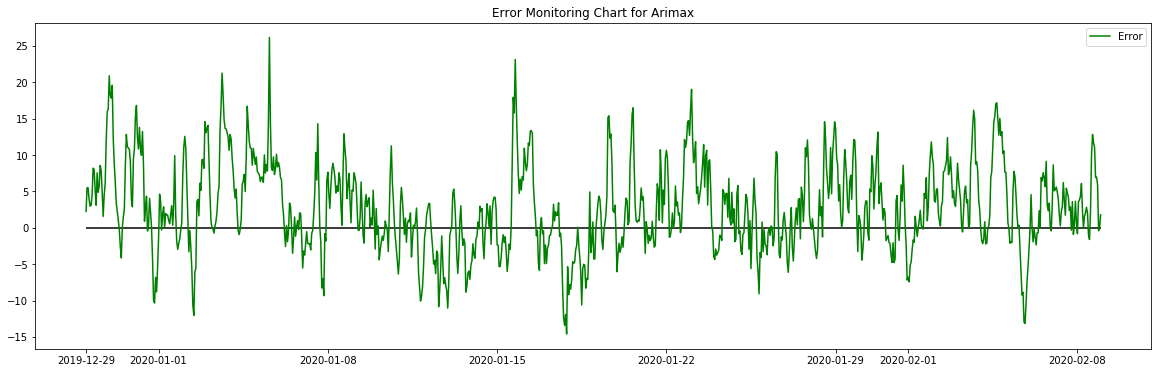

In [74]:
# Error monitoring chart for arimax
arimax_df['Error'] = test_data['Count']- arimax_df['Forecast']
plt.figure(figsize=(20,6))
plt.plot(arimax_df['Date'], arimax_df['Error'], label='Error', color='green')
plt.hlines(0, start_test, end_test)

plt.legend()
plt.title("Error Monitoring Chart for Arimax")

Text(0.5, 1.0, 'Error Monitoring Chart for DeepAR vs. Arimax')

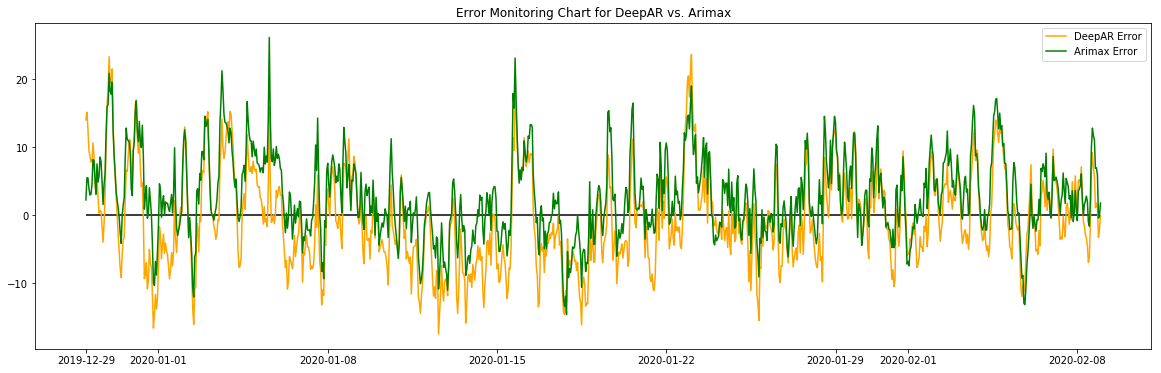

In [75]:
plt.figure(figsize=(20,6))
plt.plot(error_df['DateTime'], error_df['Error'], label='DeepAR Error', color='orange')
plt.plot(arimax_df['Date'], arimax_df['Error'], label='Arimax Error', color='green')
plt.hlines(0, start_test, end_test)

plt.legend()
plt.title("Error Monitoring Chart for DeepAR vs. Arimax")

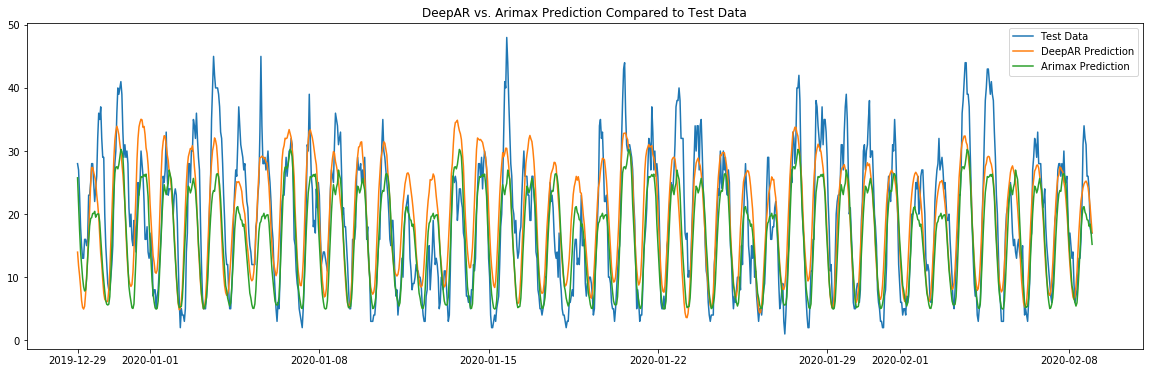

In [76]:
plt.figure(figsize=(20,6))
plt.plot(test_data['DateTime'], test_data['Count'], label='Test Data')
plt.plot(forecast_data['0.5'], label="DeepAR Prediction")
plt.plot(arimax_df['Date'], arimax_df['Forecast'], label="Arimax Prediction")
plt.legend()
plt.title("DeepAR vs. Arimax Prediction Compared to Test Data")

plt.show()

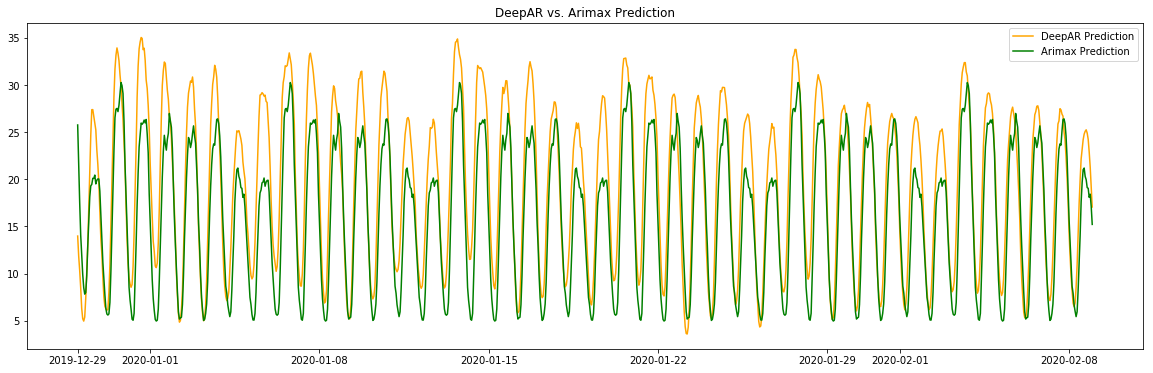

In [77]:
plt.figure(figsize=(20,6))
plt.plot(forecast_data['0.5'], label="DeepAR Prediction",color='orange')
plt.plot(arimax_df['Date'], arimax_df['Forecast'], label="Arimax Prediction", color='green')
plt.legend()
plt.title("DeepAR vs. Arimax Prediction")

plt.show()

In [78]:
# Experiment with averaging arimax and DeepAR together
combined_df = forecast_df.join(arimax_df['Forecast'])
combined_df['Avg'] = (combined_df['0.5'] + combined_df['Forecast'])/2

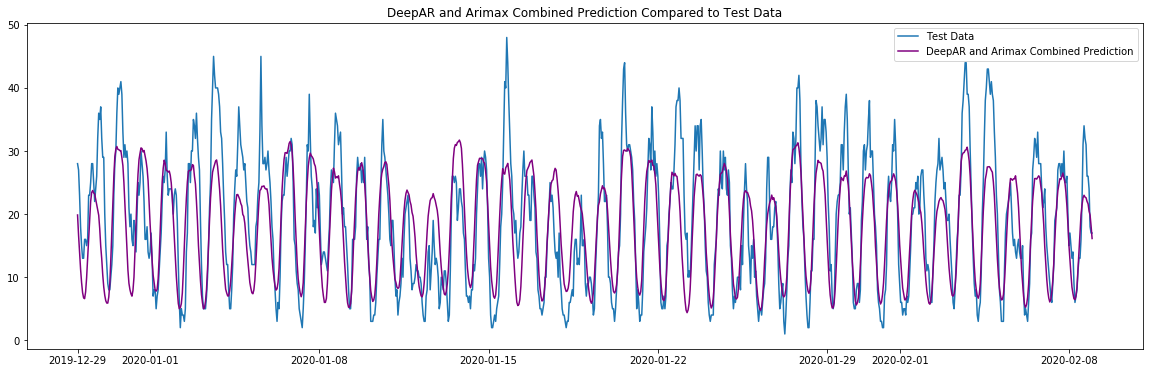

In [79]:
plt.figure(figsize=(20,6))
plt.plot(test_data['DateTime'], test_data['Count'], label='Test Data')
plt.plot(combined_df[0], combined_df['Avg'], label="DeepAR and Arimax Combined Prediction", color='purple')
plt.legend()
plt.title("DeepAR and Arimax Combined Prediction Compared to Test Data")

plt.show()

In [80]:
# Calculate Error Metrics for combined model. Should make this a function but not enough time
error_sum = 0
error_squared_sum = 0
error_percent_sum = 0
error_one_sided_sum = 0
n_oneside = 0

for i in range(forecast_data.shape[0]):
    error = test_data.at[i, 'Count'] - combined_df.at[i, 'Avg']
    if (test_data.at[i,'Count'] != 0):
        percent = 100 * error/test_data.at[i,'Count']
    else:
        percent = 0
    error_sum += abs(error)
    error_squared_sum += error**2
    error_percent_sum += abs(percent)
    if(error > 0):
        error_one_sided_sum += error
        n_oneside += 1
  
    

n = forecast_data.shape[0]
RMSE = math.sqrt(error_squared_sum/n)
MAE = error_sum/n
MAPE = error_percent_sum/n
OSE = error_one_sided_sum/n_oneside


print("MAE: ", MAE)
print("RMSE: ", RMSE)
print("MAPE: ", MAPE)
print("OSE: ", OSE)

MAE:  4.929597403736065
RMSE:  6.3282226759811735
MAPE:  37.03476892620234
OSE:  5.892113357258933


In [81]:
# Delete the endpoint after finished with modeling
#sagemaker_session.delete_endpoint(endpoint_name)